In [1]:

%run ../../load_magic/storage2 1
%who

data_folder = ../data/
saves_folder = ../saves/
attempt_to_pickle	 data_folder	 encoding	 load_csv	 load_dataframes	 load_object	 os	 pd	 pickle	 
save_dataframes	 saves_folder	 store_objects	 sys	 


In [2]:

import datetime
import math

coindesk_df = load_csv('coindesk-bpi-USD-close_data-2010-07-17_2018-06-10').dropna()

coindesk_df['Date'] = coindesk_df['Date'].map(lambda x: pd.to_datetime(x))

now_date = datetime.datetime.now()
coindesk_df['Seconds'] = coindesk_df['Date'].map(lambda x: (now_date-x).total_seconds())

s_mean = coindesk_df['Seconds'].mean()
s_max = coindesk_df['Seconds'].max()
s_min = coindesk_df['Seconds'].min()
coindesk_df['Seconds (Normed)'] = (s_mean - coindesk_df['Seconds']) / (s_max - s_min)

cp_mean = coindesk_df['Close Price'].mean()
cp_max = coindesk_df['Close Price'].max()
cp_min = coindesk_df['Close Price'].min()
coindesk_df['Close Price (Normed)'] = (coindesk_df['Close Price'] - cp_mean) / (cp_max - cp_min)

coindesk_df['Log Price'] = coindesk_df['Close Price'].map(lambda x: math.log(x))
lp_mean = coindesk_df['Log Price'].mean()
lp_max = coindesk_df['Log Price'].max()
lp_min = coindesk_df['Log Price'].min()
coindesk_df['Log Price (Normed)'] = (coindesk_df['Log Price'] - lp_mean) / (lp_max - lp_min)

store_objects(coindesk_df=coindesk_df)
coindesk_df.head(10)

Pickling to ../saves/pickle/coindesk_df.pickle


,Date,Close Price,Seconds,Seconds (Normed),Close Price (Normed),Log Price,Log Price (Normed)
0,2010-07-18,0.09,2.495465e+08,-0.499851,-0.063595,-2.407946,-0.550456
1,2010-07-19,0.08,2.494601e+08,-0.499504,-0.063596,-2.525729,-0.559611
2,2010-07-20,0.07,2.493737e+08,-0.499158,-0.063596,-2.659260,-0.569989
3,2010-07-21,0.08,2.492873e+08,-0.498811,-0.063596,-2.525729,-0.559611
4,2010-07-22,0.05,2.492009e+08,-0.498464,-0.063597,-2.995732,-0.596142
5,2010-07-23,0.06,2.491145e+08,-0.498118,-0.063597,-2.813411,-0.581971
6,2010-07-24,0.05,2.490281e+08,-0.497771,-0.063597,-2.995732,-0.596142
7,2010-07-25,0.05,2.489417e+08,-0.497425,-0.063597,-2.995732,-0.596142
8,2010-07-26,0.06,2.488553e+08,-0.497078,-0.063597,-2.813411,-0.581971
9,2010-07-27,0.06,2.487689e+08,-0.496731,-0.063597,-2.813411,-0.581971


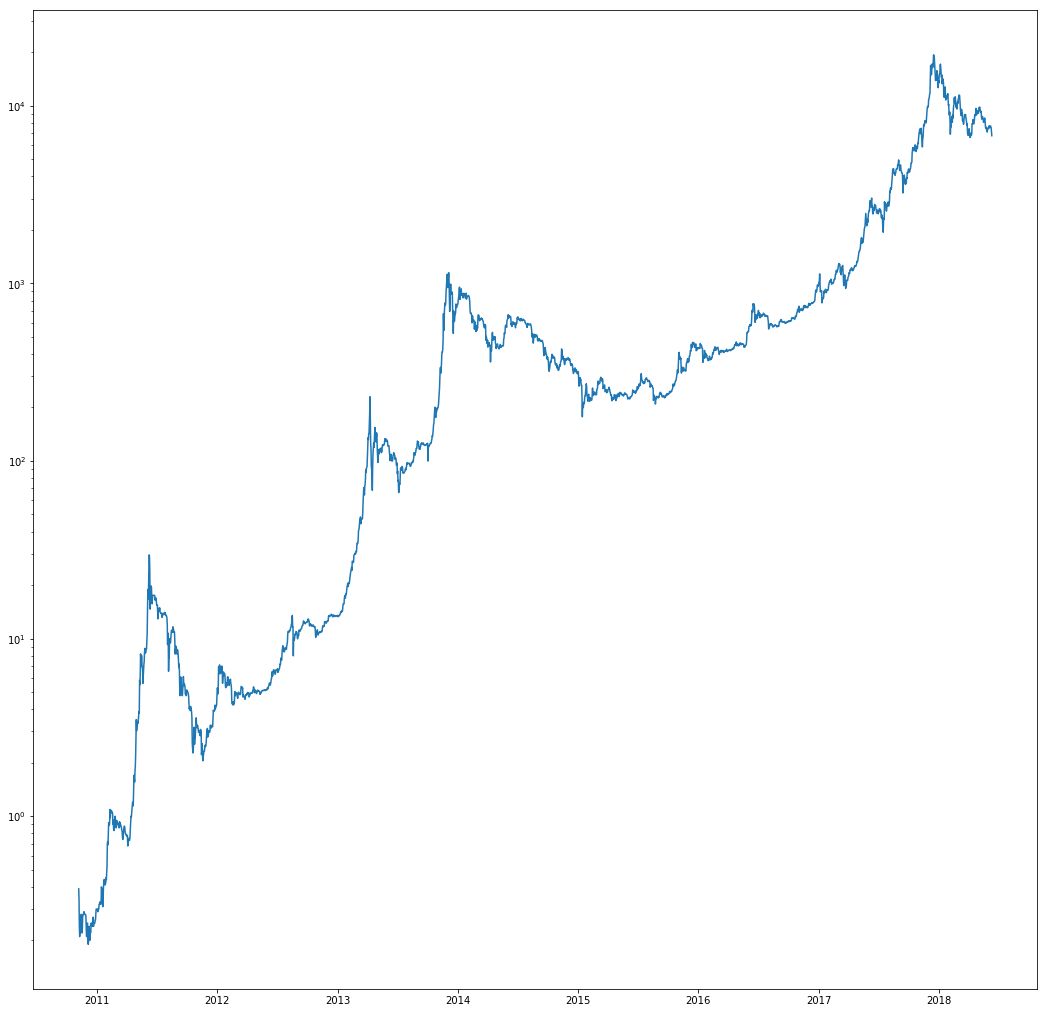

In [3]:

%matplotlib inline
import matplotlib.pyplot as plt

match_series = (coindesk_df['Seconds'].index > 110)

plt.figure(figsize=(18, 18))
plt.plot(coindesk_df[match_series]['Date'], coindesk_df[match_series]['Close Price'])
plt.yscale('log')

In [4]:

# good discussion here:  http://stackoverflow.com/questions/4308168/sigmoidal-regression-with-scipy-numpy-python-etc
# curve_fit() example from here: http://permalink.gmane.org/gmane.comp.python.scientific.user/26238
# other sigmoid functions here: http://en.wikipedia.org/wiki/Sigmoid_function

In [5]:

def sigmoid(x, x0, k):
    y = 1 / (1 + np.exp(-k*(x-x0)))
    
    return y

In [6]:

xdata = coindesk_df[match_series]['Seconds (Normed)'].as_matrix()

In [7]:

ydata = coindesk_df[match_series]['Log Price (Normed)'].as_matrix()

In [8]:

from scipy.optimize import curve_fit
import numpy as np

popt, pcov = curve_fit(sigmoid, xdata, ydata)
print(popt)

[0.55379542 6.54490788]


In [9]:

x = np.linspace(start=xdata.min(), stop=xdata.max(), num=len(xdata))
y = sigmoid(x, *popt)

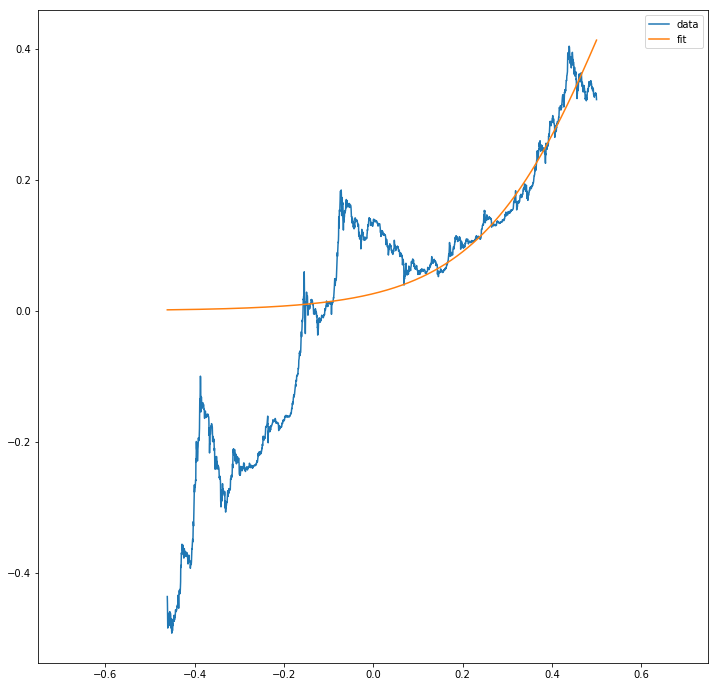

In [10]:

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.plot(xdata, ydata, label='data')
line2d = plt.plot(x, y, label='fit')
xlim_tuple = plt.xlim(-0.75, 0.75)
legend_obj = plt.legend(loc='best')

In [11]:

'''
Negative Exponential Function: y = α⋅(1 − e−β⋅x) ; β > 0
This function is called the negative exponential
function due the −β portion. It is also referred to as
the 2-parameter asymptotic exponential. Maximum price
attained by this modeling form, i.e. saturation, is α.
'''
def negative_exponential(x, a, b):
    y = a*(1 - np.exp(-b*x))
    
    return y

In [12]:

popt, pcov = curve_fit(negative_exponential, xdata, ydata)
print(popt)

[1.60842336 0.43222887]


In [13]:

x = np.linspace(start=xdata.min(), stop=xdata.max(), num=len(xdata))
y = negative_exponential(x, *popt)

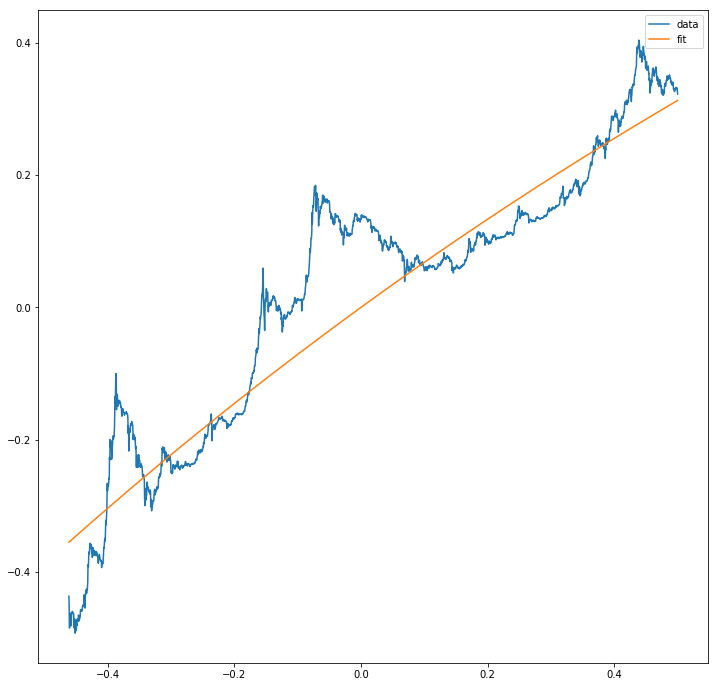

In [14]:

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.plot(xdata, ydata, label='data')
line2d = plt.plot(x, y, label='fit')
#xlim_tuple = plt.xlim(-0.75, 0.75)
legend_obj = plt.legend(loc='best')

In [15]:

y_min = []
for fit_y, y1 in zip(y, ydata):
    y_min.append(min(fit_y, y1))
y_min = np.array(y_min)

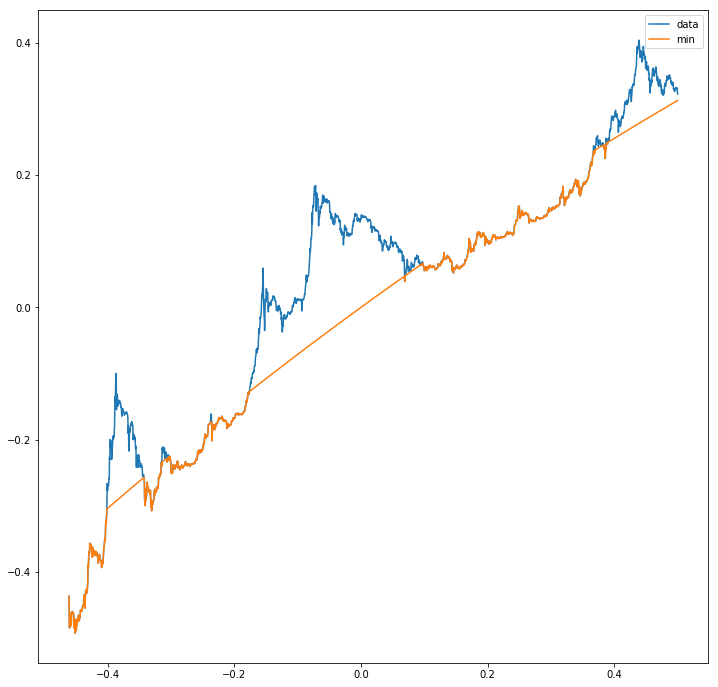

In [16]:

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.plot(xdata, ydata, label='data')
line2d = plt.plot(x, y_min, label='min')
#xlim_tuple = plt.xlim(-0.75, 0.75)
legend_obj = plt.legend(loc='best')

In [17]:

popt_min, pcov = curve_fit(negative_exponential, xdata, y_min)
print(popt_min)

[0.70640523 0.99885052]


In [18]:

y_min_fitted = negative_exponential(x, *popt_min)

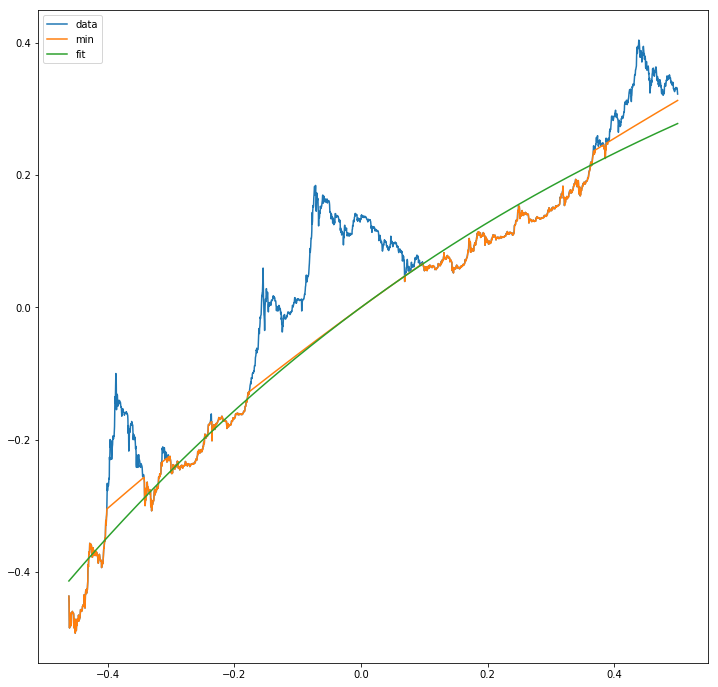

In [19]:

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.plot(xdata, ydata, label='data')
line2d = plt.plot(x, y_min, label='min')
line2d = plt.plot(x, y_min_fitted, label='fit')
#xlim_tuple = plt.xlim(-0.75, 0.75)
legend_obj = plt.legend(loc='best')

In [20]:

from sklearn.metrics import mean_squared_error
from math import sqrt

rms_error = sqrt(mean_squared_error(y_min, y_min_fitted))
while (rms_error > 0.005) and (y_min_fitted.min() >= ydata.min()):
    temp_y = []
    for fit_y, old_y in zip(y_min_fitted, y_min):
        temp_y.append(min(fit_y, old_y))
    y_min = np.array(temp_y)
    popt_min, pcov = curve_fit(negative_exponential, xdata, y_min)
    y_min_fitted = negative_exponential(x, *popt_min)
    rms_error = sqrt(mean_squared_error(y_min, y_min_fitted))

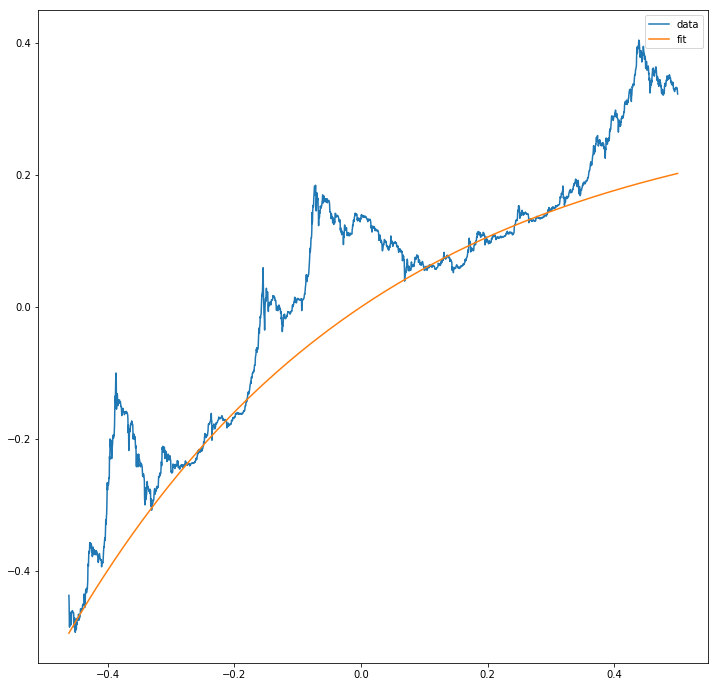

In [21]:

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.plot(xdata, ydata, label='data')
line2d = plt.plot(x, y_min_fitted, label='fit')
#xlim_tuple = plt.xlim(-0.75, 0.75)
legend_obj = plt.legend(loc='best')

In [22]:

x = np.linspace(start=xdata.min(), stop=xdata.max()+xdata.max()-xdata.min(), num=len(xdata)*2)
y = negative_exponential(x, *popt_min)

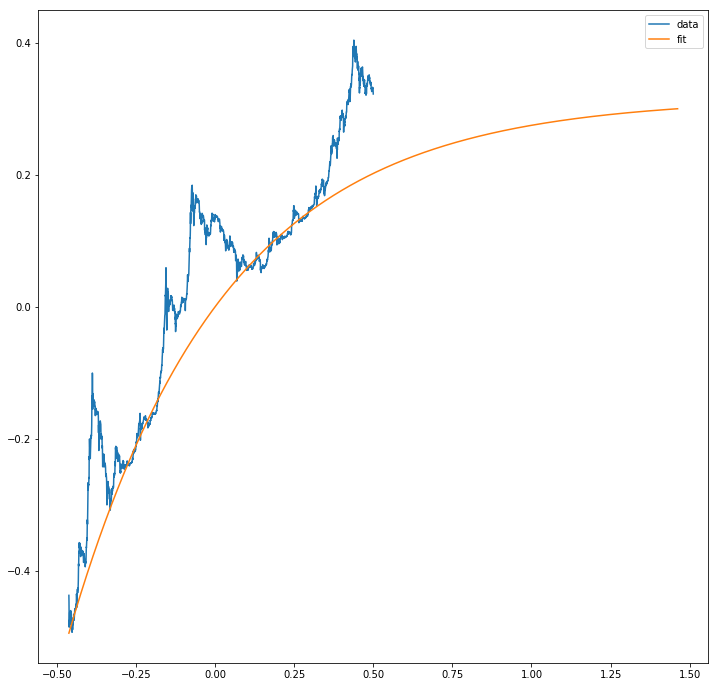

In [23]:

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.plot(xdata, ydata, label='data')
line2d = plt.plot(x, y, label='fit')
#xlim_tuple = plt.xlim(-0.75, 0.75)
legend_obj = plt.legend(loc='best')

In [24]:

from datetime import timedelta

print(now_date + timedelta(seconds=x.max()*(s_max-s_min)-s_mean))

2026-01-13 17:18:00


In [27]:

math.e**(y.max()*(lp_max-lp_min)-lp_mean)

0.4430471193074839

In [40]:

print(math.e**(ydata.max()*(lp_max-lp_min)-lp_mean)*(cp_max-cp_min)-cp_mean)
print(cp_max)
print((math.e**(ydata.max()*(lp_max-lp_min)-lp_mean))*(cp_max-cp_min)-cp_mean)

31365.3645640936
19343.04
31365.3645640936


In [32]:

print(x.max())
print(list(x)[list(y).index(y.max())])

1.4616722912256728
1.4616722912256728


In [34]:

print(xdata.max())
date_of_highest_price = list(xdata)[list(ydata).index(ydata.max())]
print(date_of_highest_price)
print(now_date + timedelta(seconds=date_of_highest_price*(s_max-s_min)-s_mean))

0.5001490228410818
0.43884261936835456
2017-12-16 00:00:00


In [45]:

def get_true_date_from_fitted_price(fitted_price):
    
    # Find the position from the list that is closest
    closest_position = min(y, key=lambda x: abs(x-fitted_price))
    
    fitted_seconds = list(x)[list(y).index(closest_position)]
    true_seconds = fitted_seconds*(s_max-s_min)-s_mean
    
    return now_date + timedelta(seconds=true_seconds)

In [47]:

print(ydata.max())
get_true_date_from_fitted_price(ydata.max())

0.40385821518079457


datetime.datetime(2026, 1, 13, 17, 18)

In [58]:

def get_log_price_from_fitted_seconds(fitted_seconds):
    
    # Find the position from the list that is closest
    closest_position = min(x, key=lambda y: abs(y-fitted_seconds))
    
    fitted_price = list(y)[list(x).index(closest_position)]
    fitted_log = math.e**fitted_price
    log_price = fitted_log*(lp_max-lp_min)-lp_mean
    
    return log_price

In [57]:

fitted_seconds = xdata.min()
print('fitted_seconds: {}'.format(fitted_seconds))
closest_position = min(x, key=lambda y: abs(y-fitted_seconds))
print('closest_position: {}'.format(closest_position))
fitted_price = list(y)[list(x).index(closest_position)]
print('fitted_price: {}'.format(fitted_price))
fitted_log = math.e**fitted_price
print('fitted_log: {}'.format(fitted_log))
log_price = fitted_log*(lp_max-lp_min)-lp_mean
print('log_price: {}'.format(log_price))

fitted_seconds: -0.4613742455435093
closest_position: -0.4613742455435093
fitted_price: -0.49367693052083317
fitted_log: 0.6103779457253705
log_price: 3.1788921603584823


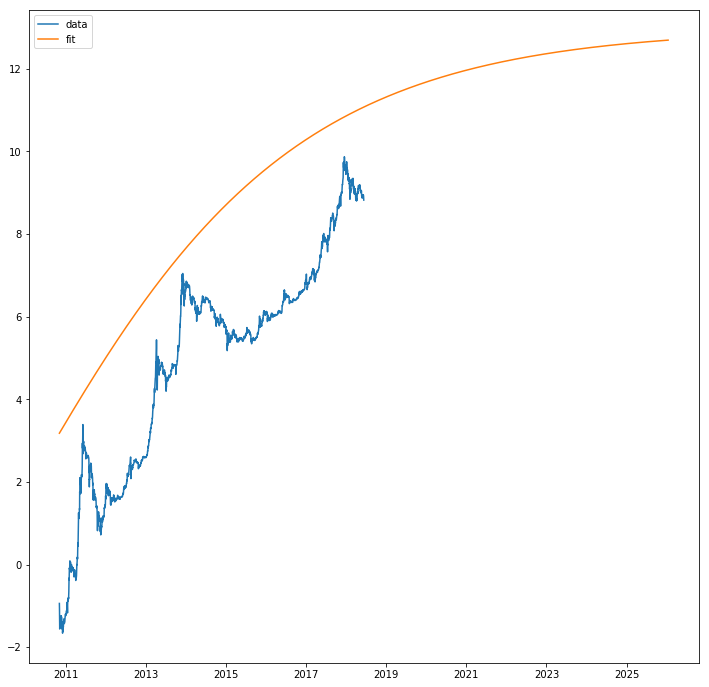

In [59]:

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.plot(coindesk_df[match_series]['Date'], coindesk_df[match_series]['Log Price'], label='data')
x_true_date = []
for fitted_price in y:
    x_true_date.append(get_true_date_from_fitted_price(fitted_price))
y_log_price = []
for fitted_seconds in x:
    y_log_price.append(get_log_price_from_fitted_seconds(fitted_seconds))
line2d = plt.plot(x_true_date, y_log_price, label='fit')
legend_obj = plt.legend(loc='best')